# Project 1: Fake News Detection Using Machine Learning 

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [3]:
true = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv")

In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake['label'] = 0
true['label'] = 1
df = pd.concat([fake, true], ignore_index=True) # Merge Data

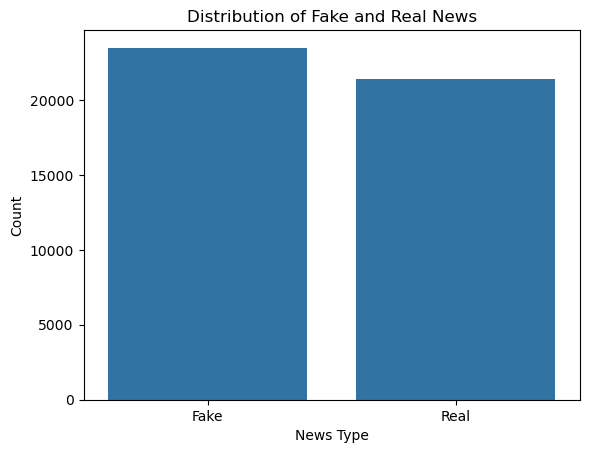

In [7]:
# Exploratory data analysis (EDA)/ Data Visualisation

# 1. Class Distribution (Fake vs Real News)

sns.countplot(data=df, x='label')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title('Distribution of Fake and Real News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

This bar chart comparing the total count of articles labeled as Fake versus Real shows:

There is a slightly higher number of fake news articles than real ones.

The dataset is fairly balanced, which is beneficial for training a machine learning model, as it reduces the risk of bias toward the majority class.

The near-equal representation supports robust and fair model training and evaluation.

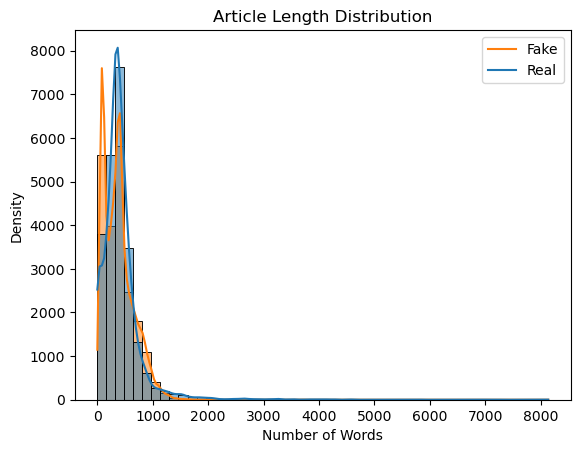

In [9]:
# 2. Article Length Distribution

df['text_length'] = df['text'].apply(lambda x: len(x.split()))

sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title("Article Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.legend(labels=["Fake", "Real"])
plt.show()

Histogram with density curves of the number of words per article, separated by Fake and Real labels shows:

Both Fake and Real articles are mostly shorter than 1000 words, with a sharp drop-off as the word count increases.

Fake news articles tend to have a slightly shorter average length compared to real ones.

The overlap between the two distributions suggests that while article length alone may not fully distinguish between fake and real news, it is a useful feature when combined with others.

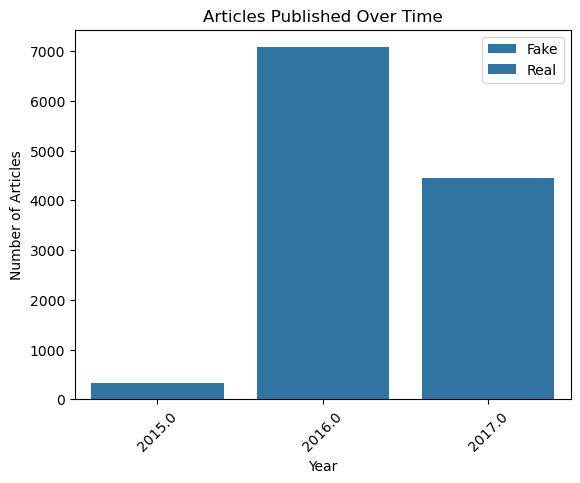

In [11]:
# 3. News Articles Over Time

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

sns.countplot(data=df.dropna(subset=['year']), x='year', hue='label')
plt.title("Articles Published Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.legend(labels=['Fake', 'Real'])
plt.show()

This bar chart shows the number of articles published by year (2015, 2016, 2017). The peak year is 2016, with the highest volume of articles. 2017 shows a decline, and 2015 has very few articles.

This temporal trend may reflect real-world events or data collection practices during that period. Time-related features (e.g., year or month) might offer additional predictive value in models or trend-based analysis.

In [13]:
# Text Cleaning and Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

df['cleaned_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vasavinagesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Feature Extraction
vectorizer = TfidfVectorizer(max_df=0.7)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

In [15]:
# Train/Test Split & Modeling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4733
           1       0.98      0.98      0.98      4247

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



The model performs equally well for both classes with balanced precision, recall, and F1-score. 

Macro and weighted averages reaffirm that performance is consistent across class distributions.

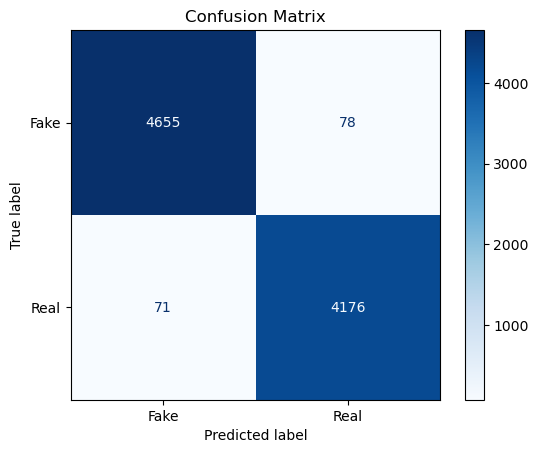

In [17]:
# Model Performance Visualizations

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Both False Positives (71) and False Negatives (78) are quite low, indicating the classifier is well-balanced in detecting both classes. This shows that the model performs exceptionally well, with very high accuracy, precision, and recall.

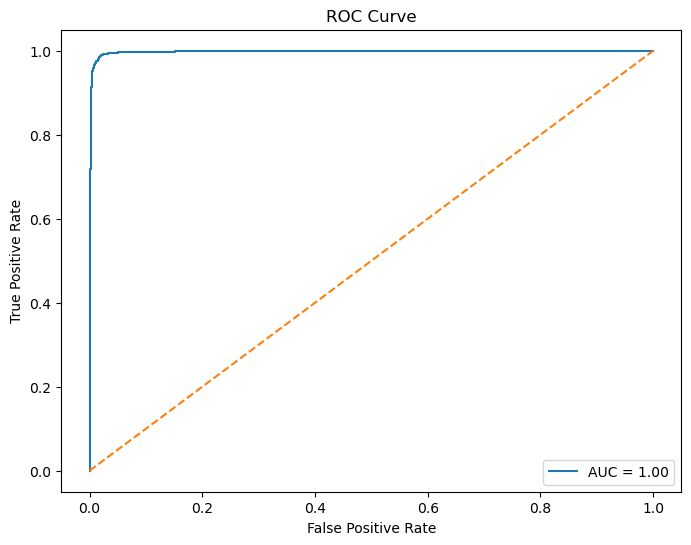

In [19]:
# ROC Curve

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

True Positive Rate close to 1 across almost all FPR values shows that the classifier detects fake/real news with high sensitivity.

False Positive Rate remains near 0 shows very few real news items are misclassified as fake.

AUC = 1.00 is the ideal score showing the model can perfectly distinguish between fake and real news, regardless of threshold.

### Final Takeaways/Summary/Conclusion

Balanced data and feature differences (like article length) enhance the model's learning.

The classifier delivers robust performance with high accuracy and minimal errors.

Strong feature insights from EDA could be valuable for feature engineering or further interpretability.

The model is deployment-ready, given its consistent metrics, clean data distribution, and interpretability.